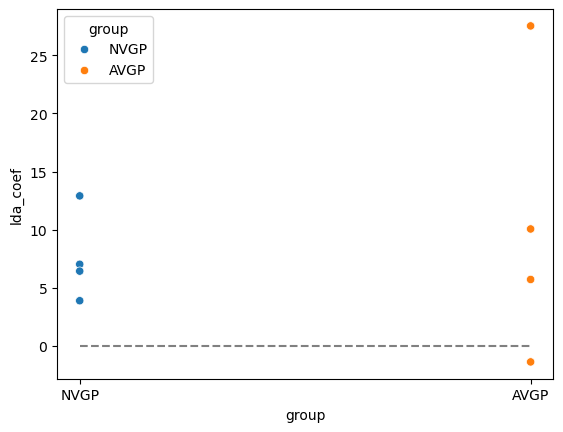

In [67]:
%reload_ext autoreload
%autoreload 2

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from src.acnets.pipeline import (
    Parcellation, ConnectivityPipeline, ConnectivityVectorizer)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# DATA
subjects = (Parcellation(atlas_name='dosenbach2010')
     .fit_transform(None).coords['subject'].values)

y_encoder = LabelEncoder()
y = y_encoder.fit_transform([s[:4] for s in subjects])

preproc  = Pipeline([
    ('connectivity', ConnectivityPipeline(kind='partial correlation',
                                          connectivity_aggregation='network')),
    ('vectorize', ConnectivityVectorizer()),
    ('scale', StandardScaler()),
    ('zerovar', VarianceThreshold()),
    # ('clf', SVC(kernel='linear', C=1))
])

X = preproc.fit_transform(subjects)

cv = StratifiedShuffleSplit(n_splits=2, test_size=0.25)
splits = list(cv.split(X, y))
train, test = splits[0]

estimator = LinearDiscriminantAnalysis(solver='svd', store_covariance=True)

results = pd.DataFrame({'subject': subjects[test],
                        'group': [s[:4] for s in subjects[test]],
                        'lda_coef': estimator.fit(X[train], y[train]).transform(X[test]).reshape(-1)})

# results = pd.DataFrame({'subject': subjects,
#                         'group': [s[:4] for s in subjects],
#                         'lda_coef': estimator.fit(X, y).transform(X).reshape(-1)})


sns.scatterplot(data=results, x='group', y='lda_coef', hue='group')
plt.hlines(0, 0, 1, color='gray', linestyle='--')

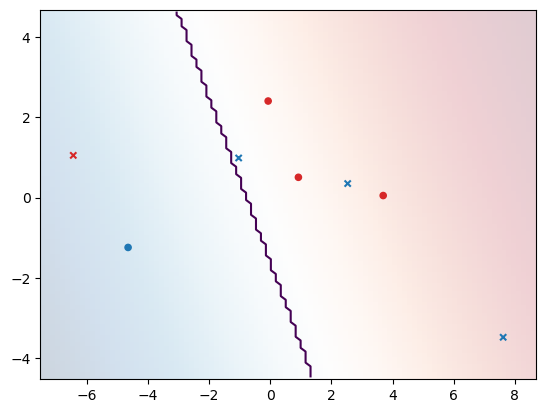

In [68]:
X_pca = PCA(n_components=2).fit_transform(X)

estimator = SVC(probability=True, kernel='linear', C=1)
estimator = estimator.fit(X_pca[train], y[train])

y_pred = estimator.predict(X_pca[test])
right_mask = y[test] == y_pred
X_right = X_pca[test][right_mask]
X_wrong = X_pca[test][~right_mask]
y_right = y[test][right_mask]
y_wrong = y[test][~right_mask]

# plot
fig, ax = plt.subplots()
cmap = colors.ListedColormap(["tab:red", "tab:blue"])
DecisionBoundaryDisplay.from_estimator(estimator, X_pca,
                                       response_method="predict_proba",
                                       plot_method="pcolormesh",
                                       ax=ax,
                                       cmap="RdBu", alpha=0.2,
)
DecisionBoundaryDisplay.from_estimator(estimator, X_pca,
                                       response_method='predict_proba', plot_method='contour', alpha=1.0,
                                       ax=ax,
                                       levels=[0.5])

ax.scatter(X_right[:, 0], X_right[:, 1], c=y_right, s=20, cmap=cmap)
ax.scatter(
    X_wrong[:, 0],
    X_wrong[:, 1],
    c=y_wrong,
    s=20,
    marker='x',
    cmap=cmap,
    )


In [62]:
# unsupervised outliers

from sklearn.svm import OneClassSVM
import numpy as np


# pd.DataFrame({'subject': subjects[test],
#               'y': y[test],
#               'label': np.where(y_pred == -1, 'outlier', y[test])})

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score

def remove_outliers(X, y):
    X0 = X[y == 0]
    X1 = X[y == 1]
    detector = OneClassSVM(kernel='linear', nu=0.1)
    y0 = detector.fit(X0).predict(X0)
    y1 = detector.fit(X1).predict(X1)
    X_out = np.concatenate([X0, X1])
    y_out = np.concatenate([y0, y1])
    X_out = X_out[y_out == 1]
    y0 = y[y==0][y0 == 1]
    y1 = y[y==1][y1 == 1]
    y_out = np.concatenate([y0, y1])
    return X_out, y_out

def evaluate(subjects):

    y = LabelEncoder().fit_transform([s[:4] for s in subjects])

    pipe  = Pipeline([
        ('connectivity', ConnectivityPipeline(kind='partial correlation',
                                            connectivity_aggregation='network')),
        ('vectorize', ConnectivityVectorizer()),
        ('scale', StandardScaler()),
        ('zerovar', VarianceThreshold()),
        ('clf', SVC(kernel='linear', C=1))
    ])

    cv = StratifiedShuffleSplit(n_splits=1000, test_size=8)

    scores = cross_val_score(pipe, subjects, y, cv=cv, n_jobs=-1, verbose=1)
    return scores

evaluate(subjects).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s


KeyboardInterrupt: 